Название проекта: Анализ курсов на платформе "Stepik".

В моем проекте я  определю самые популярные категории курсов на Stepik, долю платных и бесплатных курсов, иностранных и русских, а также популярных и непопулярных, выявлю основные тенденции и узнаю, какие курсы преобладают на этой платформе.





# Код для парсинга

In [7]:
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import os
from dotenv import load_dotenv

load_dotenv()
mypassword = os.getenv("MYPASSWORD")


def clean_description(html_text):
    if not html_text:
        return ""
    soup = BeautifulSoup(html_text, 'lxml')
    return ' '.join(soup.stripped_strings)

def fetch_page(page, api_url_base, headers):
    try:
        response = requests.get(f'{api_url_base}?page={page}', headers=headers, timeout=10)
        if response.status_code == 200:
            return json.loads(response.text).get('courses', [])
    except:
        return []
    return []

def get_active_courses(api_url_base, token, max_courses=600):
    all_courses = []
    headers = {'Authorization': f'Bearer {token}'}

    # Преобразование списков в множества по классификациям для быстрого поиска
    search_words = [ "python", "питон", "java", "javascript", "c++", "c#", "go", "ruby", "rust",
    "kotlin", "swift", "php", "typescript", "react", "angular", "vue", "node.js","html", "css", "веб-разработк", "frontend", "backend", "fullstack",
    "django", "flask", "laravel", "spring", "wordpress",
    "android", "ios", "react native", "flutter",
    "data science", "машинное обучение", "ai", "нейросет", "nlp",
    "computer vision", "pandas", "numpy", "tensorflow", "pytorch",
    "sql", "postgresql", "mysql", "mongodb", "redis", "clickhouse",
    "docker", "kubernetes", "terraform", "ansible", "ci/cd", "gitlab", "jenkins",
    "кибербезопасност", "ethical hacking", "penetration testing", "сетевая безопасность",
    "git", "linux", "bash", "aws", "azure", "gcp"]
    business_words = ["бизнес", "менеджмент", "предпринимательство", "стартап", "фриланс",
    "маркетинг", "digital marketing", "smm", "контент-маркетинг", "копирайтинг",
    "scrum", "agile", "kanban", "product management",
    "hr", "рекрутинг", "team lead", "управление командой",
    "финансы", "инвестици", "трейдинг", "форекс", "криптовалюты", "блокчейн",
    "бухгалтери", "налогообложени", "финтех",
    "b2b", "b2c", "crm",
    "бизнес-аналитика", "power bi", "tableau", "google analytics",
    "business", "management", "startup", "entrepreneurship", "fintech", "crypto"]
    art_words = ["дизайн", "graphic design", "figma", "adobe photoshop",
    "illustrator", "indesign", "coreldraw", "веб-дизайн", "типографика",
    "бренд-дизайн", "логотип", "анимаци", "motion design", "blender",
    "фотографи", "photo", "видеосъемк", "монтаж видео", "premiere pro",
    "цветокоррекци",
    "рисовани", "живопис", "скетчинг", "digital art", "3d моделирование",
    "скульптур", "каллиграфи", "граффити",
    "музык", "звукозапись", "fl studio", "ableton",
    "гитара", "фортепиано", "вокал", "саунд-дизайн",
    "копирайтинг", "сторителлинг", "сценаристика", "поэзия",
    "handmade", "вязание", "шитье",
    "креативность", "арт", "творчество"]
    language_words = ["английский", "english", "англ", "ielts", "toefl",
        "немецкий", "deutsch", "goethe",
        "французский", "français", "delf",
        "испанский", "español", "dele",
        "итальянский", "italiano",
        "китайский", "mandarin", "hsk", "汉语",
        "японский", "日本語", "jlpt", "nihongo",
        "корейский", "한국어", "topik",
        "языковой", "изучение языка", "курс языка",
        "разговорный", "грамматика", "vocabulary",
        "pronunciation", "перевод", "переводчик",
        "polyglot", "bilingual", "trilingual",
        "foreign language", "языковая школа",
        "tutor", "языковая практика"]
    health_words = ["фитнес", "тренировк", "йог", "пилатес", "стретчинг", "кроссфит",
    "бодибилдинг", "аэробик", "functional training",
    "здоровь", "зож", "правильное питание", "pp", "нутрициологи",
    "детокс", "велнес", "медитаци", "осознанность", "mental health",
    "первая помощь", "медицин", "анатомия", "физиотерапия", "массаж",
    "реабилитация", "спортивная медицина", "геронтология",
    "бокс", "муай тай", "дзюдо", "карате", "самбо", "борьба", "кикбоксинг",
    "танцы", "хип-хоп", "бальные танцы", "современные танцы", "бачата", "сальса",
    "скалолазани", "серфинг", "сноуборд", "лыжи", "велоспорт",
    "спорт", "fitness", "workout", "health", "wellness", "rehabilitation"]

    # Загрузка страницы параллельно (по 3 одновременно)
    with ThreadPoolExecutor(max_workers=3) as executor:
        page = 1
        while len(all_courses) < max_courses:
            futures = [executor.submit(fetch_page, p, api_url_base, headers)
                      for p in range(page, page+3)]
            page += 3

            for future in futures:
              courses = future.result()
              for course in courses:
                    if course.get('is_active') and len(all_courses) < max_courses:
                        all_courses.append(course)

              if len(all_courses) >= max_courses:
                    break

  # Разделяем курсы на категории
    tech_courses = []
    business_courses = []
    art_courses = []
    language_courses = []
    health_courses = []

    for course in all_courses:
        description = course.get('description', '').lower()
        clean_desc = clean_description(description) if course.get('description') else ""

        course_data = {
            'тип': '',
            'название': course['title'],
            'id': course['id'],
            'оплата': "платный" if course['is_paid'] else "бесплатный",
            'язык': "русский" if course['language'] == 'ru' else "иностранный",
            'популярность': "популярный" if course['is_popular'] else "непопулярный",
            'описание': clean_desc
        }

        if any(word in description for word in search_words):
            course_data['тип'] = 'компьютерные технологии'
            tech_courses.append(course_data)
        elif any(word in description for word in business_words):
            course_data['тип'] = 'бизнес и менеджмент'
            business_courses.append(course_data)
        elif any(word in description for word in art_words):
            course_data['тип'] = 'творчество и дизайн'
            art_courses.append(course_data)
        elif any(word in description for word in language_words):
            course_data['тип'] = 'иностранные языки и линвистика'
            language_courses.append(course_data)
        elif any(word in description for word in health_words):
            course_data['тип'] = 'здоровье и спорт'
            health_courses.append(course_data)

    # Объединение в нужном порядке
    return (tech_courses + business_courses + art_courses +
            language_courses + health_courses)
# Использование
api_url_base = 'https://stepic.org/api/courses'
token = os.getenv("MYPASSWORD")


sorted_courses = get_active_courses(api_url_base, token)
# Вывод в JSON
json_output = json.dumps(sorted_courses, ensure_ascii=False, indent=4)
print(json_output)
df = pd.DataFrame(sorted_courses)

# Сохраняем в файл
df.to_csv("../data/output_table.csv", index=False, encoding='utf-8-sig')

[
    {
        "тип": "компьютерные технологии",
        "название": "Твой путь в AI - PyTorch и Numpy!",
        "id": 241982,
        "оплата": "платный",
        "язык": "русский",
        "популярность": "популярный",
        "описание": "курс по нейронным сетям с pytorch - это интенсивный курс, который предназначен для тех, кто хочет научиться создавать и обучать нейронные сети с использованием библиотеки pytorch. при прохождении курса по numpy вы разовьёте навыки работы с массивами данных, математическими и статистическими операциями и другими концепциями, которые будут полезны во многих областях, включая научные и инженерные вычисления, обработку данных и машинное обучение. чему вы научитесь: работать с pytorch. превращать данные в dataset. создавать модели нейронных сетей. тренировать нейронные сети. сохранять и загружать готовые модели. работать с массивами numpy. выполнять векторизованные операции. использовать математические и статистические функции. разберётесь с транслиро

# EDA и статистика

In [8]:
print("\n" + "="*50)
print("Примеры курсов из каждой категории:")
print("="*50)

# Получаем список всех категорий
categories = df['тип'].unique()

examples = []

# Для каждой категории берем первый попавшийся курс
for category in categories:
    example = df[df['тип'] == category].iloc[0:1]
    examples.append(example)

examples_df = pd.concat(examples)

# Настраиваем отображение
pd.set_option('display.max_colwidth', 40)

# Выводим
display(examples_df[['тип', 'название', 'оплата', 'язык', 'популярность']])


# Информация о типах данных и пропущенных значениях
print("\nИнформация о датафрейме:")
df.info()

# Подсчет пропущенных значений
print("\nКоличество пропущенных значений:")
display(df.isnull().sum())

# Подсчет уникальных значений в категориальных столбцах
print("\nКоличество уникальных значений:")
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col}: {df[col].nunique()} уникальных значений")
    if df[col].nunique() < 10:  # Показываем значения только если их немного
        print("Значения:", df[col].unique())

# Базовая статистика для текстовых описаний
print("\nСтатистика длины описаний:")
df['длина_описания'] = df['описание'].str.len()
display(df['длина_описания'].describe())

# Поиск выбросов в числовых данных
def find_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers

outliers = find_outliers(df, 'длина_описания')
print("\nКоличество выбросов в длине описания:", len(outliers))
if len(outliers) > 0:
    print("Примеры выбросов:")
    display(df.loc[outliers.index, ['название', 'длина_описания']].head(3))







Примеры курсов из каждой категории:


,тип,название,оплата,язык,популярность
0,компьютерные технологии,Твой путь в AI - PyTorch и Numpy!,платный,русский,популярный
96,бизнес и менеджмент,Математический кружок.ВТОРОЙ год обу...,платный,русский,непопулярный
124,творчество и дизайн,ЕГЭ-2025 по русскому: прожарка ЛЕГКИ...,платный,русский,непопулярный
181,иностранные языки и линвистика,In a dressmaker's establishment.,бесплатный,иностранный,непопулярный
200,здоровье и спорт,Гребля на байдарках для начинающих,бесплатный,русский,непопулярный



Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   тип           218 non-null    object
 1   название      218 non-null    object
 2   id            218 non-null    int64 
 3   оплата        218 non-null    object
 4   язык          218 non-null    object
 5   популярность  218 non-null    object
 6   описание      218 non-null    object
dtypes: int64(1), object(6)
memory usage: 12.1+ KB

Количество пропущенных значений:


тип             0
название        0
id              0
оплата          0
язык            0
популярность    0
описание        0
dtype: int64


Количество уникальных значений:
тип: 5 уникальных значений
Значения: ['компьютерные технологии' 'бизнес и менеджмент' 'творчество и дизайн'
 'иностранные языки и линвистика' 'здоровье и спорт']
название: 218 уникальных значений
оплата: 2 уникальных значений
Значения: ['платный' 'бесплатный']
язык: 2 уникальных значений
Значения: ['русский' 'иностранный']
популярность: 2 уникальных значений
Значения: ['популярный' 'непопулярный']
описание: 215 уникальных значений

Статистика длины описаний:


count     218.000000
mean     1102.591743
std      1104.261257
min        83.000000
25%       463.500000
50%       781.000000
75%      1389.000000
max      9551.000000
Name: длина_описания, dtype: float64


Количество выбросов в длине описания: 15
Примеры выбросов:


,название,длина_описания
9,Docs as Code: Документация как код д...,2924
27,Системный аналитик Middle,4744
28,Проектирование архитектуры микросерв...,3554


1. Разделение курсов по категориям



In [9]:
category_dist = df['тип'].value_counts()
print("Распределение курсов по категориям:")
display(category_dist)

Распределение курсов по категориям:


тип
компьютерные технологии           96
творчество и дизайн               57
бизнес и менеджмент               28
иностранные языки и линвистика    19
здоровье и спорт                  18
Name: count, dtype: int64

Видно, что больше всего преобладают по колличеству технические курсы

2. Доля платных и бесплатных курсов.

In [12]:
payment_analysis = pd.crosstab(df['тип'], df['оплата'], normalize='index')*100
print("\nДоля платных/бесплатных курсов по категориям (%):")
display(payment_analysis.style)


Доля платных/бесплатных курсов по категориям (%):


оплата,бесплатный,платный
тип,,
бизнес и менеджмент,60.714286,39.285714
здоровье и спорт,72.222222,27.777778
иностранные языки и линвистика,89.473684,10.526316
компьютерные технологии,54.166667,45.833333
творчество и дизайн,84.210526,15.789474


Видно, что бесплатных курсов в каждой категории больше, чем платных.

3. Доля популярных курсов.

In [13]:
popularity_analysis = pd.crosstab(df['тип'], df['популярность'], normalize='index')*100
print("\nДоля популярных курсов по категориям (%):")
display(popularity_analysis.style)


Доля популярных курсов по категориям (%):


популярность,непопулярный,популярный
тип,,
бизнес и менеджмент,71.428571,28.571429
здоровье и спорт,94.444444,5.555556
иностранные языки и линвистика,94.736842,5.263158
компьютерные технологии,43.750000,56.250000
творчество и дизайн,84.210526,15.789474


Во всех категориях, кроме "Компьютерные технологии", непопулярных курсов больше, чем популярных.

4. Доля русскоязычных курсов.

In [14]:
language_analysis = pd.crosstab(df['тип'], df['язык'], normalize='index')*100
print("\nДоля русскоязычных курсов по категориям (%):")
display(language_analysis.style)


Доля русскоязычных курсов по категориям (%):


язык,иностранный,русский
тип,,
бизнес и менеджмент,3.571429,96.428571
здоровье и спорт,11.111111,88.888889
иностранные языки и линвистика,21.052632,78.947368
компьютерные технологии,14.583333,85.416667
творчество и дизайн,17.543860,82.456140


Видно, что русских курсов преобладающее большинство

# Визуализация и анализ

У меня довольно много данных для анализа, поэтому я решила сделать больше визуализаций: круговая и столбчатая диаграммы, Heatmap, plotly и облако слов из описания курсов

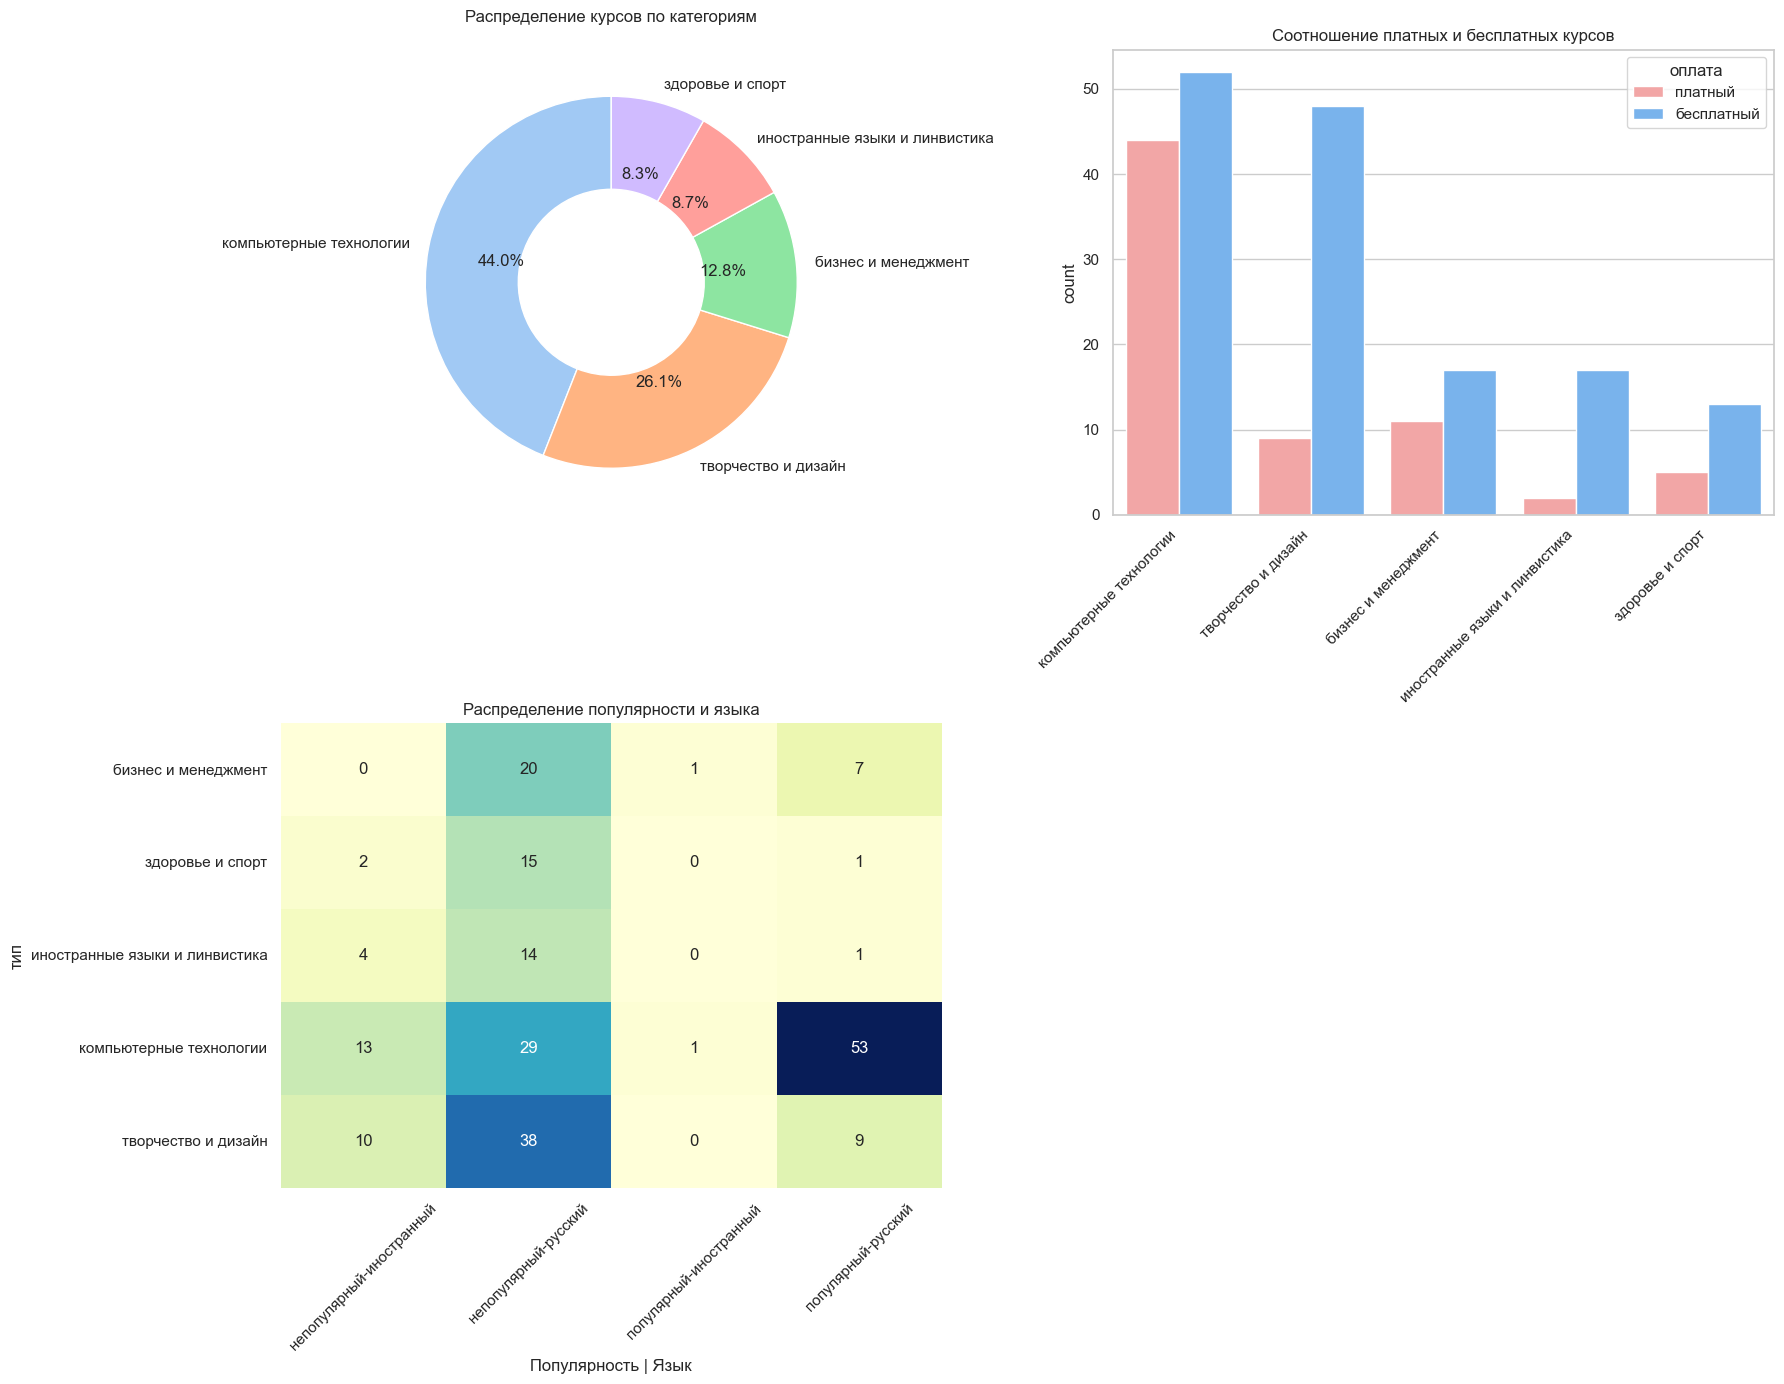

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка стиля
sns.set_theme(style="whitegrid")
plt.figure(figsize=(18, 14))

# 1 Круговая диаграмма распределения категорий
plt.subplot(2, 2, 1)
category_dist = df['тип'].value_counts()
plt.pie(category_dist, labels=category_dist.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette("pastel"),
        wedgeprops={'width': 0.5})
plt.title("Распределение курсов по категориям", pad=20)

# 2 Столбчатая диаграмма платных/бесплатных курсов
plt.subplot(2, 2, 2)
sns.countplot(data=df, x='тип', hue='оплата',
             palette=['#ff9999','#66b3ff'], order=category_dist.index)
plt.title("Соотношение платных и бесплатных курсов")
plt.xticks(rotation=45, ha='right')
plt.xlabel('')

# 3 Heatmap популярности и языка
plt.subplot(2, 2, 3)
cross_tab = pd.crosstab(df['тип'], [df['популярность'], df['язык']])
sns.heatmap(cross_tab, annot=True, fmt='d', cmap="YlGnBu", cbar=False)
plt.title("Распределение популярности и языка")
plt.xticks(rotation=45)
plt.xlabel('Популярность | Язык')

plt.tight_layout()
plt.show()

1. Распределение курсов по категориям

По этой диаграмме можно сделать вывод о том, что Stepik преимущественно ориентирован на технические (из-за высокого рыночного спроса на digital-профессии и потому что платформа изначально создавалась для IT-образования) и творческие курсы ( отчасти из-за доступности инструментов (Figma, Photoshop), что упрощает обучение).

Бизнес-курсы занимают меньшую долю, чем IT (возможно, потому что есть конкуренция с узкоспециализированными платформами (например, Coursera для MBA)).

Языки и лингвистика также занимают малую долю от числа курсов (из-за доминирования мобильных приложений (Duolingo, Lingualeo), которые удобнее для изучения языков, а также из-за меньшей монетизации — языковые курсы чаще бесплатны).

Здоровье и спорт занимает самую малую долю среди всех курсов ( т.к. существуют офлайн-альтернативы (тренажерные залы, секции), которые пока эффективнее для этой сферы, низкий спрос на узкие темы)

2. Соотношение платных и бесплатных курсов

В первую очередь, можно заметить, что бесплатные курсы доминируют над платными во всех категориях, но при этом платных курсов тоже не мало.

Технические курсы:
IT курсов максимальное количество как платных, так и бесплатных курсов, а соотношение примерно 1:3 ( это может быть потому что быстрое устаревание знаний делает платные курсы менее востребованными)

В бизнес-сегменте разница между платными и бесплатными наименьшая по сравнению с другими категориями (отчасти это потому что в бизнес-образовании платность воспринимается как признак качества)

Творческие и иностранные курсы имеют меньше всего платных курсов в соотношении с бесплатными (из-за конкуренции с другими бесплатными платформами, творческие - конкуренцией с YouTube, языковые - мобильные приложения)

В категории здоровья соотношение примерно 50/50, в этой ситуации сложно делать выводы, т.к. количество очень маленькое, но можно предположить, что такое соотношение из-за конкуренции и с бесплатными видео с ютуба и с дорогими оффлайн-программами.
3. Распределение популярности и языка

Заметим, что иностранных курсов в каждой категории достаточно мало и все эти курсы, за исключением одного, непопулярные, поэтому можно сделать вывод о том, что "Stepik" больше рассчинан на русскоязычную аудиторию. Заметим, что в IT и творчестве больше всего иностранных курсов (IT и творческое направления, по результатам проведённой работы  самые популярные на платформе "Stepik", и поэтому была высокая вероятность, что именно в этих категориях будет большее количество иностранных курсов). Также важно заметить, что в категории "иностранные языки и лингвистика" в процентном соотношении больше всего иностранных курсов, это во многом зависит от специфики категории, но, как видно на графике, эти курсы менее популярны (как и почти все курсы из этой категории на платформе "Stepik"), поэтому можно сделать вывод о том, что аудитория платформы мало пользуется "Stepik" с целью изучения языков и чаще всего прибегают к другим способам, например, занятия с репетиторами или на других платформах, такие как "duolingo".

In [19]:
import plotly.express as px

# Подготовка данных
plotly_df = df.groupby(['тип', 'оплата', 'популярность']).size().reset_index(name='count')

# Создание диаграммы
fig = px.sunburst(
    plotly_df,
    path=['тип', 'оплата', 'популярность'],
    values='count',
    color='тип',
    color_discrete_sequence=px.colors.qualitative.Pastel,
    title="Иерархическое распределение курсов"
)
fig.update_layout(margin=dict(t=50, l=0, r=0, b=0))
fig.show()

По этой диаграмме можно сделать вывод о том, что либо все, либо большинство бесплатных курсов в каждой категории непопулярные, а платные наоборот популярные. Такое происходит из-за того, что платные курсы привлекают мотивированных учащихся, профессионалов, ищущих углубленные знания и корпоративных клиентов. Популярные платные курсы получают больше рекомендаций, доступ к лучшим преподавателям и возможности партнерств, а бесплатные курсы теряются в массе аналогичных предложений.

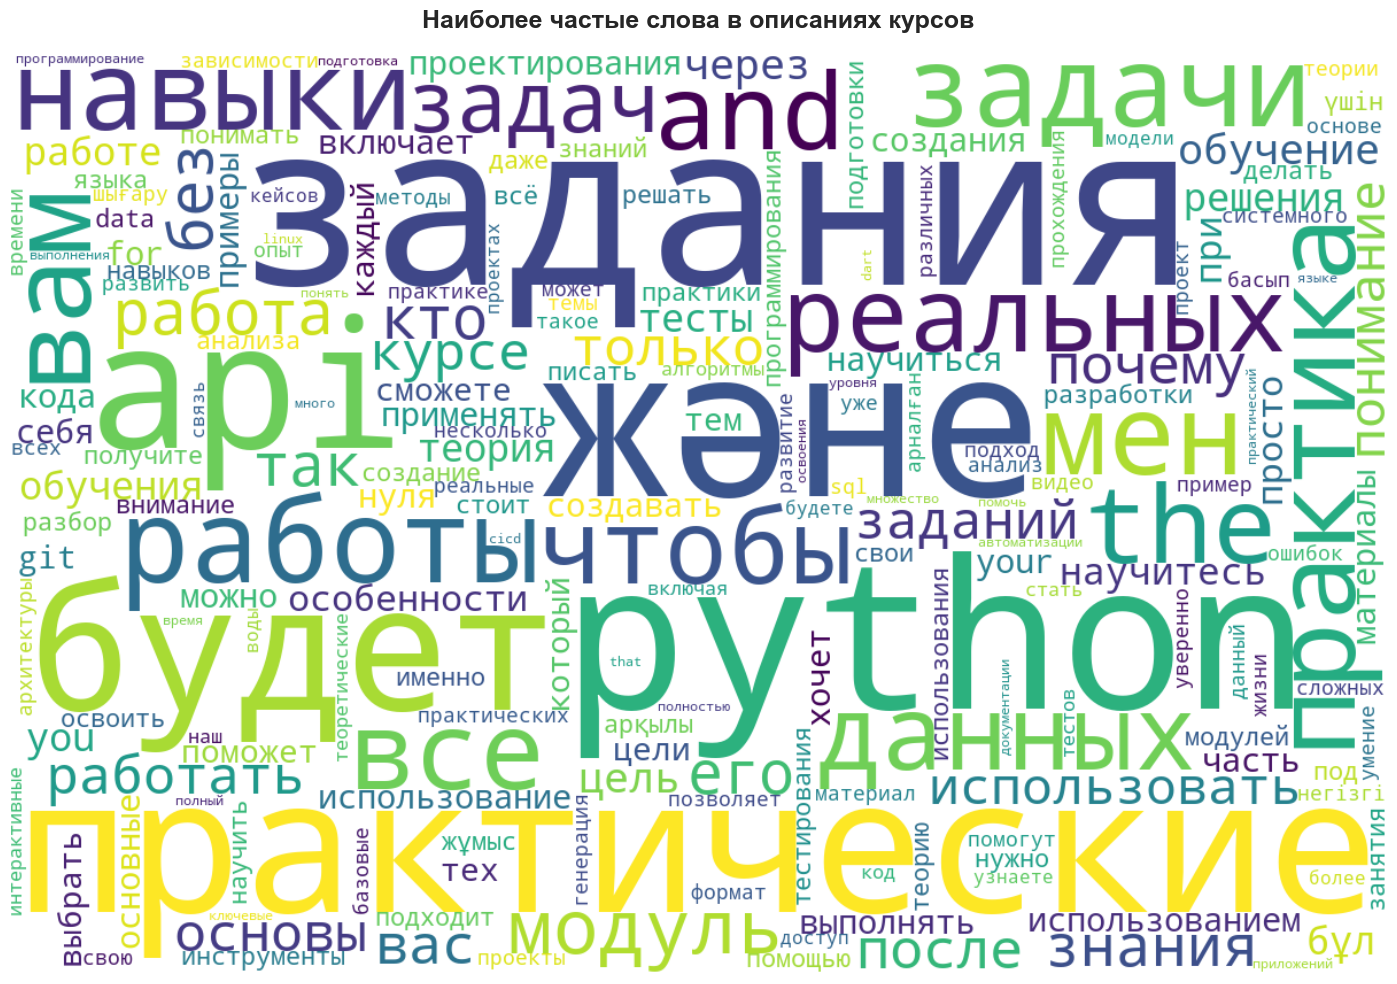

In [21]:
# Импортируем необходимые библиотеки
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Функция для предварительной обработки текста
def preprocess_text(text):
    # Удаляем спецсимволы и цифры
    text = re.sub(r'[^\w\s]', '', text, flags=re.UNICODE)
    text = re.sub(r'\d+', '', text)
    # Приводим к нижнему регистру
    return text.lower()

# Проверяем наличие данных в колонке description
if 'описание' not in df.columns:
    raise ValueError

# Собираем и обрабатываем весь текст
all_text = ' '.join(df['описание'].dropna().astype(str))

# Проверяем, что текст не пустой
if len(all_text.strip()) == 0:
    raise ValueError("Текст для облака слов пустой")

# Обрабатываем текст
processed_text = preprocess_text(all_text)

# Создаем список стоп-слов
russian_stopwords = {'и', 'в', 'на', 'с', 'по', 'для', 'как', 'от', 'из', 'это',
                    'что', 'курс', 'курсы', 'курса', 'которые', 'или', 'если', 'но', 'также', 'этот'}

# Создаем частотный словарь
words = processed_text.split()
filtered_words = [word for word in words if word not in russian_stopwords and len(word) > 2]
word_freq = Counter(filtered_words)

# Проверяем, что есть слова для отображения
if not word_freq:
    raise ValueError("После фильтрации не осталось слов для облака")

# Создаем облако слов
wordcloud = WordCloud(
    width=1200,
    height=800,
    background_color='white',
    colormap='viridis',
    max_words=200,
    contour_width=1,
    contour_color='steelblue',
    min_font_size=10,
    max_font_size=200,
    collocations=False,
    stopwords=russian_stopwords,
    font_path=None,
    prefer_horizontal=0.9
).generate_from_frequencies(word_freq)

# Отображаем облако слов
plt.figure(figsize=(16, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Наиболее частые слова в описаниях курсов", pad=20, size=18, weight='bold')
plt.tight_layout()
plt.show()

1. Можно заметить доминирование практико-ориентированной лексики ("практика", "задания", работа" и т.д.). Это свидетельствует о сильном акценте на прикладном применении знаний.

2. Технический уклон содержания. Слова "python", "программирования", "прибор", "анализа" подтверждают ориентацию на IT и технические дисциплины

3. Казахский язык является растущим сегментом на платформе (примерно 5-7%). Особенно популярны курсы, которые являются локализованными версиями русскоязычных IT-курсов.





# Общий вывод

Главная особенность платформы — практическое обучение в сфере компьютерных технологий и творчества. Около 50% курсов посвящены IT-направлениям, это обусловлено растущим спросом на цифровые профессии и изначальной специализацией платформы на технических дисциплинах.

Значительную часть составляют программы по дизайну и творчеству. Их популярность объясняется простотой освоения современных цифровых инструментов.

Реже встречаются курсы по бизнесу и менеджменту (13,6%), иностранным языкам (10,8%), а также здоровью и спорту (6,6%). Это связано с высокой конкуренцией со стороны узкоспециализированных платформ (например, Coursera для бизнес-образования или Duolingo для языков), а также с тем, что некоторые направления, вроде фитнеса, эффективнее изучать офлайн.

Основные особенности:

1. Бесплатный контент, но при этом платные курсы (особенно в IT и бизнесе) тоже востребованы. Они часто оказываются популярнее бесплатных аналогов, так как привлекают более мотивированную аудиторию).

2. Ориентация на русскоязычных пользователей. Большинство популярных программ доступны только на русском, а иностранные курсы остаются малоизвестными.

3. Практический подход.
В описаниях часто встречаются слова «практика», «задания», «данные», что подчеркивает прикладной характер обучения.

"Stepik" — это платформа, на которой преобладают бесплатные практико-ориентированные курсы по IT и творческим дисциплинам, рассчитанные в первую очередь на русскоязычных пользователей, с акцентом на получение прикладных знаний и навыков, востребованных в современном цифровом мире.